In [2]:
# general purpose packages
import pandas as pd
import numpy as np
import sqlite3
import re
import os

from datetime import datetime
import pickle

# visualization related packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from wordcloud import WordCloud

# text preprocessing related packages
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

# feature extraction related packages
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# partition data to train & test
from sklearn.model_selection import train_test_split
# saving sparse matrix
import scipy.sparse

# Stack Overflow: Tag Prediction

<h1>1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p style='font-size:18px'><b> Description </b></p>
<p>
Stack Overflow is the largest, most trusted online community for developers to learn, share their programming knowledge, and build their careers.<br />
<br />
Stack Overflow is something which every programmer use one way or another. Each month, over 50 million developers come to Stack Overflow to learn, share their knowledge, and build their careers. It features questions and answers on a wide range of topics in computer programming. The website serves as a platform for users to ask and answer questions, and, through membership and active participation, to vote questions and answers up or down and edit questions and answers in a fashion similar to a wiki or Digg. As of April 2014 Stack Overflow has over 4,000,000 registered users, and it exceeded 10,000,000 questions in late August 2015. Based on the type of tags assigned to questions, the top eight most discussed topics on the site are: Java, JavaScript, C#, PHP, Android, jQuery, Python and HTML.<br />
<br />
</p>

<p style='font-size:18px'><b> Problem Statemtent </b></p>
Suggest the tags based on the content that was there in the question posted on Stackoverflow.

<p style='font-size:18px'><b> Source:  </b> https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/</p>


<h2> 1.2 Source / useful links </h2>

Data Source : https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/data <br>
Youtube : https://youtu.be/nNDqbUhtIRg <br>
Research paper : https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tagging-1.pdf <br>
Research paper : https://dl.acm.org/citation.cfm?id=2660970&dl=ACM&coll=DL

<h2> 1.3 Real World / Business Objectives and Constraints </h2>

1. Predict as many tags as possible with high precision and recall.
2. Incorrect tags could impact customer experience on StackOverflow.
3. No strict latency constraints.

<h1>2. Machine Learning problem </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

Refer: https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/data
<br>
All of the data is in 2 files: Train and Test.<br />
<pre>
<b>Train.csv</b> contains 4 columns: Id,Title,Body,Tags.<br />
<b>Test.csv</b> contains the same columns but without the Tags, which you are to predict.<br />
<b>Size of Train.csv</b> - 6.75GB<br />
<b>Size of Test.csv</b> - 2GB<br />
<b>Number of rows in Train.csv</b> = 6034195<br />
</pre>
The questions are randomized and contains a mix of verbose text sites as well as sites related to math and programming. The number of questions from each site may vary, and no filtering has been performed on the questions (such as closed questions).<br />
<br />


__Data Field Explaination__

Dataset contains 6,034,195 rows. The columns in the table are:<br />
<pre>
<b>Id</b> - Unique identifier for each question<br />
<b>Title</b> - The question's title<br />
<b>Body</b> - The body of the question<br />
<b>Tags</b> - The tags associated with the question in a space-seperated format (all lowercase, should not contain tabs '\t' or ampersands '&')<br />
</pre>

<br /><h3>

<h3>2.1.2 Example Data point </h3>

<pre>
<b>Title</b>:  Implementing Boundary Value Analysis of Software Testing in a C++ program?
<b>Body </b>: <pre><code>
        #include&lt;
        iostream&gt;\n
        #include&lt;
        stdlib.h&gt;\n\n
        using namespace std;\n\n
        int main()\n
        {\n
                 int n,a[n],x,c,u[n],m[n],e[n][4];\n         
                 cout&lt;&lt;"Enter the number of variables";\n         cin&gt;&gt;n;\n\n         
                 cout&lt;&lt;"Enter the Lower, and Upper Limits of the variables";\n         
                 for(int y=1; y&lt;n+1; y++)\n         
                 {\n                 
                    cin&gt;&gt;m[y];\n                 
                    cin&gt;&gt;u[y];\n         
                 }\n         
                 for(x=1; x&lt;n+1; x++)\n         
                 {\n                 
                    a[x] = (m[x] + u[x])/2;\n         
                 }\n         
                 c=(n*4)-4;\n         
                 for(int a1=1; a1&lt;n+1; a1++)\n         
                 {\n\n             
                    e[a1][0] = m[a1];\n             
                    e[a1][1] = m[a1]+1;\n             
                    e[a1][2] = u[a1]-1;\n             
                    e[a1][3] = u[a1];\n         
                 }\n         
                 for(int i=1; i&lt;n+1; i++)\n         
                 {\n            
                    for(int l=1; l&lt;=i; l++)\n            
                    {\n                 
                        if(l!=1)\n                 
                        {\n                    
                            cout&lt;&lt;a[l]&lt;&lt;"\\t";\n                 
                        }\n            
                    }\n            
                    for(int j=0; j&lt;4; j++)\n            
                    {\n                
                        cout&lt;&lt;e[i][j];\n                
                        for(int k=0; k&lt;n-(i+1); k++)\n                
                        {\n                    
                            cout&lt;&lt;a[k]&lt;&lt;"\\t";\n               
                        }\n                
                        cout&lt;&lt;"\\n";\n            
                    }\n        
                 }    \n\n        
                 system("PAUSE");\n        
                 return 0;    \n
        }\n
        </code></pre>\n\n
        <p>The answer should come in the form of a table like</p>\n\n
        <pre><code>       
        1            50              50\n       
        2            50              50\n       
        99           50              50\n       
        100          50              50\n       
        50           1               50\n       
        50           2               50\n       
        50           99              50\n       
        50           100             50\n       
        50           50              1\n       
        50           50              2\n       
        50           50              99\n       
        50           50              100\n
        </code></pre>\n\n
        <p>if the no of inputs is 3 and their ranges are\n
        1,100\n
        1,100\n
        1,100\n
        (could be varied too)</p>\n\n
        <p>The output is not coming,can anyone correct the code or tell me what\'s wrong?</p>\n'
<b>Tags </b>: 'c++ c'
</pre>

<h2>2.2 Mapping the real-world problem to a Machine Learning Problem </h2>

<p> It is a multi-label classification problem  <br>
<b>Multi-label Classification</b>: Multilabel classification assigns to each sample a set of target labels. This can be thought as predicting properties of a data-point that are not mutually exclusive, such as topics that are relevant for a document. A question on Stackoverflow might be about any of C, Pointers, FileIO and/or memory-management at the same time or none of these. <br>
__Credit__: http://scikit-learn.org/stable/modules/multiclass.html
</p>

<h3>2.2.2 Performance metric </h3>

<b>Micro-Averaged F1-Score (Mean F Score) </b>: 
The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

<i>F1 = 2 * (precision * recall) / (precision + recall)</i><br>

In the multi-class and multi-label case, this is the weighted average of the F1 score of each class. <br>

<b>'Micro f1 score': </b><br>
Calculate metrics globally by counting the total true positives, false negatives and false positives. This is a better metric when we have class imbalance.
<br>

<b>'Macro f1 score': </b><br>
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
<br>

https://www.kaggle.com/wiki/MeanFScore <br>
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html <br>
<br>
<b> Hamming loss </b>: The Hamming loss is the fraction of labels that are incorrectly predicted. <br>
https://www.kaggle.com/wiki/HammingLoss <br>

# Configs

In [3]:
df_path = '/media/amd_3/20DAD539DAD50BC2/DSET_REPO/DataSets/CS06_STACK_OVERFLOW_TAG/Train.csv'
raw_db_path = './data/raw_data.db'
cleaned_csv_path = './data/cleaned_data.csv'
all_tags_csv_path = './data/all_tags_df.csv'

# path of final features frames
final_train_feat_path = './data/train_feat_sparse_matrix.npz'
final_test_feat_path = './data/test_feat_sparse_matrix.npz'

# 
sample_size= 300000 # the size of sample to be used for Final DF generation
title_weight= 3 # the weight to be assigned for title field for vectorization

# Read the data

In [11]:
def load_to_db(df_path, raw_db_path):
    
    print(datetime.now(), ' Loading the raw data to database')
    
    if os.path.isfile(raw_db_path):
        print('Database already present in the path !!!')
        all_tags_df = pd.read_csv(all_tags_csv_path, index_col=False)
        return all_tags_df

    # establish a connection to DB
    conn = sqlite3.connect(raw_db_path)

    # set the chunk size
    chunk_size = 100000

    # read data frame chunk by chunk
    df_chunk_reader = pd.read_csv(df_path, names=['Id', 'Title', 'Body', 'Tags'], 
                                  chunksize=chunk_size, encoding='utf-8')

    # process one chunk at a time
    for chunk_number, chunk_df in enumerate(df_chunk_reader):
        chunk_df.to_sql('raw_data', conn, if_exists='append', index=False)
        print(datetime.now(), ' Processed chunk: ', chunk_number + 1)
    
    # count the number of rows in the data base
    num_rows = pd.read_sql_query("""SELECT count(*) FROM raw_data""", conn)
    print('Number of rows in the database before deduping:', '\n', 
          num_rows['count(*)'].values[0])
    
    # Dedupe the data
    df_no_dup = pd.read_sql_query("""SELECT Id, Title, Body, Tags, COUNT(*) as
                                     cnt_dup FROM raw_data GROUP BY Title, Body, Tags""", 
                                  conn)
    
    print(datetime.now(), 'dedupe operation completed ')
    
    print("number of duplicate questions :", 
          num_rows['count(*)'].values[0]- df_no_dup.shape[0], 
          "(",(1-((df_no_dup.shape[0])/(num_rows['count(*)'].values[0])))*100,"% )")
    
    
    print('Number of times each question appeared: \n', 
          df_no_dup.cnt_dup.value_counts())
    
    
    # keep only the required columns
    df_no_dup = df_no_dup[['Id', 'Title', 'Body', 'Tags']]
    
    # create a data frame of all tags df
    all_tags_df = df_no_dup[['Id', 'Tags']]
    all_tags_df.to_csv(all_tags_csv_path, index=False)
    
    df_no_dup.to_sql('raw_data', conn, if_exists='replace', index=False)
    print(datetime.now(), ' Completed loading of raw data to DB')

    # close the connection
    conn.close()
    
    return all_tags_df

In [12]:
all_tags_df = load_to_db(df_path, raw_db_path)

2019-06-25 00:17:17.157805  Loading the raw data to database
2019-06-25 00:17:23.779355  Processed chunk:  1
2019-06-25 00:17:29.241675  Processed chunk:  2
2019-06-25 00:17:34.722642  Processed chunk:  3
2019-06-25 00:17:40.121638  Processed chunk:  4
2019-06-25 00:17:45.494259  Processed chunk:  5
2019-06-25 00:17:51.231266  Processed chunk:  6
2019-06-25 00:17:56.858416  Processed chunk:  7
2019-06-25 00:18:02.142860  Processed chunk:  8
2019-06-25 00:18:07.866116  Processed chunk:  9
2019-06-25 00:18:13.454907  Processed chunk:  10
2019-06-25 00:18:18.797847  Processed chunk:  11
2019-06-25 00:18:24.587638  Processed chunk:  12
2019-06-25 00:18:30.222038  Processed chunk:  13
2019-06-25 00:18:35.818718  Processed chunk:  14
2019-06-25 00:18:41.417359  Processed chunk:  15
2019-06-25 00:18:47.008024  Processed chunk:  16
2019-06-25 00:18:52.655092  Processed chunk:  17
2019-06-25 00:18:58.291011  Processed chunk:  18
2019-06-25 00:19:03.975847  Processed chunk:  19
2019-06-25 00:19:

# Exploratoty Data Analysis

In [4]:
all_tags_df = pd.read_csv(all_tags_csv_path, index_col=False)
print(all_tags_df.shape)
all_tags_df.head()

(4206315, 2)


/home/amd_3/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Id,Tags
0,1078065,c++ c
1,940626,c# silverlight data-binding
2,1484628,c# silverlight data-binding columns
3,1074875,jsp jstl
4,3954566,java jdbc


In [11]:
print('Id column contains NaN :', all_tags_df['Id'].isnull().any())
print('Tags column contains NaN :', all_tags_df['Tags'].isnull().any())

Id column contains NaN : False
Tags column contains NaN : True


In [12]:
all_tags_df = all_tags_df.fillna('__')
print('Tags column contains NaN :', all_tags_df['Tags'].isnull().any())

Tags column contains NaN : False


## 1. Number of Unique Tags

In [25]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
tag_vectorized = vectorizer.fit_transform(all_tags_df['Tags'])

In [26]:
print('Total number of questions ', tag_vectorized.shape[0])
print('Total number of Tags ', tag_vectorized.shape[1])

Total number of questions  4206315
Total number of Tags  42049


## 2. Number of times a Tag appeared 

In [27]:
tag_count_dict = dict(zip(vectorizer.get_feature_names(), 
                                     tag_vectorized.sum(axis=0).A1))
tag_count_df = pd.DataFrame({'Tag':vectorizer.get_feature_names(), 
                             'Count':tag_vectorized.sum(axis=0).A1}, 
                            columns=['Tag', 'Count'])
tag_count_df = tag_count_df.sort_values(['Count'], ascending=False)
tag_count_df.head()

,Tag,Count
4338,c#,331505
18070,java,299414
27250,php,284103
18158,javascript,265423
1235,android,235436


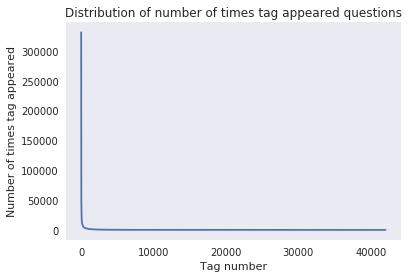

In [28]:
plt.plot(tag_count_df['Count'].values)
#plt.xticks(tag_count_df['Tag'].values)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
plt.close()

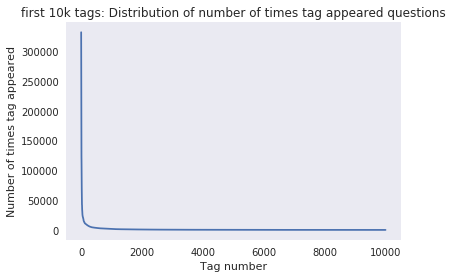

400 [331505  44829  22429  17728  13364  11162  10029   9148   8054   7151
   6466   5865   5370   4983   4526   4281   4144   3929   3750   3593
   3453   3299   3123   2986   2891   2738   2647   2527   2431   2331
   2259   2186   2097   2020   1959   1900   1828   1770   1723   1673
   1631   1574   1532   1479   1448   1406   1365   1328   1300   1266
   1245   1222   1197   1181   1158   1139   1121   1101   1076   1056
   1038   1023   1006    983    966    952    938    926    911    891
    882    869    856    841    830    816    804    789    779    770
    752    743    733    725    712    702    688    678    671    658
    650    643    634    627    616    607    598    589    583    577
    568    559    552    545    540    533    526    518    512    506
    500    495    490    485    480    477    469    465    457    450
    447    442    437    432    426    422    418    413    408    403
    398    393    388    385    381    378    374    370    367    365
  

In [29]:
plt.plot(tag_count_df['Count'].values[0:10000])
plt.title('first 10k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
plt.close()
print(len(tag_count_df['Count'].values[0:10000:25]), 
      tag_count_df['Count'].values[0:10000:25])

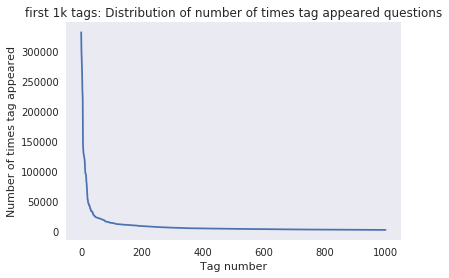

200 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703
  13364  13157  12407  11658  11228  11162  10863  10600  10350  10224
  10029   9884   9719   9411   9252   9148   9040   8617   8361   8163
   8054   7867   7702   7564   7274   7151   7052   6847   6656   6553
   6466   6291   6183   6093   5971   5865   5760   5577   5490   5411
   5370   5283   5207   5107   5066   4983   4891   4785   4658   4549
   4526   4487   4429   4335   4310   4281   4239   4228   4195   4159
   4144   4088   4050   4002   3957   3929   3874   3849   3818   3797
   3750   3703   3685   3658   3615   3593   3564   3521   3505   3483
   3453   3427   3396   3363   3326   3299   3272   3232   3196   3168
   3123   3094   3073   3050   3012   2986   2983   2953   2934   2903
   2891   2844   2819   2784   2754   2738   2726   2708   2681   2669
   2647   2621   2604   2594   2556   2527   2510   2482   2460   2444
  

In [30]:
plt.plot(tag_count_df['Count'].values[0:1000])
plt.title('first 1k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
plt.close()
print(len(tag_count_df['Count'].values[0:1000:5]), 
      tag_count_df['Count'].values[0:1000:5])

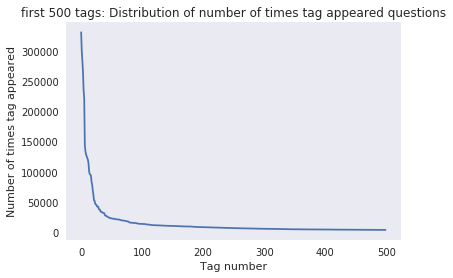

100 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703
  13364  13157  12407  11658  11228  11162  10863  10600  10350  10224
  10029   9884   9719   9411   9252   9148   9040   8617   8361   8163
   8054   7867   7702   7564   7274   7151   7052   6847   6656   6553
   6466   6291   6183   6093   5971   5865   5760   5577   5490   5411
   5370   5283   5207   5107   5066   4983   4891   4785   4658   4549
   4526   4487   4429   4335   4310   4281   4239   4228   4195   4159
   4144   4088   4050   4002   3957   3929   3874   3849   3818   3797
   3750   3703   3685   3658   3615   3593   3564   3521   3505   3483]


In [31]:
plt.plot(tag_count_df['Count'].values[0:500])
plt.title('first 500 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
plt.close()
print(len(tag_count_df['Count'].values[0:500:5]), 
      tag_count_df['Count'].values[0:500:5])

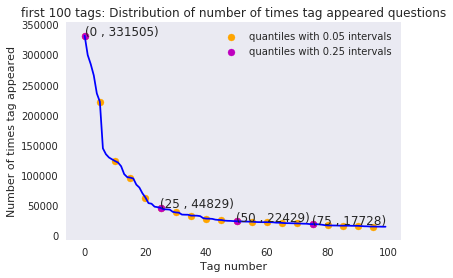

20 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703]


In [32]:
plt.plot(tag_count_df['Count'].values[0:100], c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_count_df['Count'].values[0:100:5],
            c='orange', label='quantiles with 0.05 intervals')
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,100,25)), y=tag_count_df['Count'].values[0:100:25], 
            c='m', label='quantiles with 0.25 intervals')

for x,y in zip(list(range(0,100,25)), tag_count_df['Count'].values[0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel('Tag number')
plt.ylabel('Number of times tag appeared')
plt.legend()
plt.show()
plt.close()
print(len(tag_count_df['Count'].values[0:100:5]), 
      tag_count_df['Count'].values[0:100:5])

In [33]:
# Store tags greater than 10K in one list
lst_tags_gt_10k = tag_count_df[tag_count_df['Count']> 10000].Tag
#Print the length of the list
print ('{} Tags are used more than 10000 times'.format(len(lst_tags_gt_10k)))
# Store tags greater than 100K in one list
lst_tags_gt_100k = tag_count_df[tag_count_df['Count']>100000].Tag
#Print the length of the list.
print ('{} Tags are used more than 100000 times'.format(len(lst_tags_gt_100k)))

153 Tags are used more than 10000 times
14 Tags are used more than 100000 times


<b>Observations:</b><br />
1. There are total 153 tags which are used more than 10000 times.
2. 14 tags are used more than 100000 times.
3. Most frequent tag (i.e. c#) is used 331505 times.
4. Since some tags occur much more frequenctly than others, Micro-averaged F1-score is the appropriate metric for this probelm.

## 3.2.4 Tags Per Question 

In [34]:
tag_per_question = tag_vectorized.sum(axis=1).A1

question_tag_count_df = pd.DataFrame({'Question': range(0, tag_per_question.shape[0]), 
                             'Tag_Count':tag_per_question})

In [35]:
print('Maximum number of tags per question: %d'%(question_tag_count_df['Tag_Count'].max(),))
print('Minimum number of tags per question: %d'%(question_tag_count_df['Tag_Count'].min(),))
print('Avg. number of tags per question: %f'%(question_tag_count_df['Tag_Count'].mean(),))

Maximum number of tags per question: 5
Minimum number of tags per question: 1
Avg. number of tags per question: 2.899439


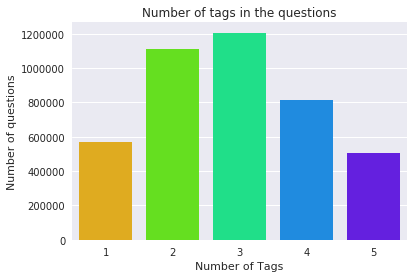

In [36]:
sns.countplot(data=question_tag_count_df, x='Tag_Count', 
              palette='gist_rainbow')
plt.title('Number of tags in the questions')
plt.xlabel('Number of Tags')
plt.ylabel('Number of questions')
plt.show()
plt.close()

<b>Observations:</b><br />
1. Maximum number of tags per question: 5
2. Minimum number of tags per question: 1
3. Avg. number of tags per question: 2.899
4. Most of the questions are having 2 or 3 tags

## 3.2.5 Most Frequent Tags 

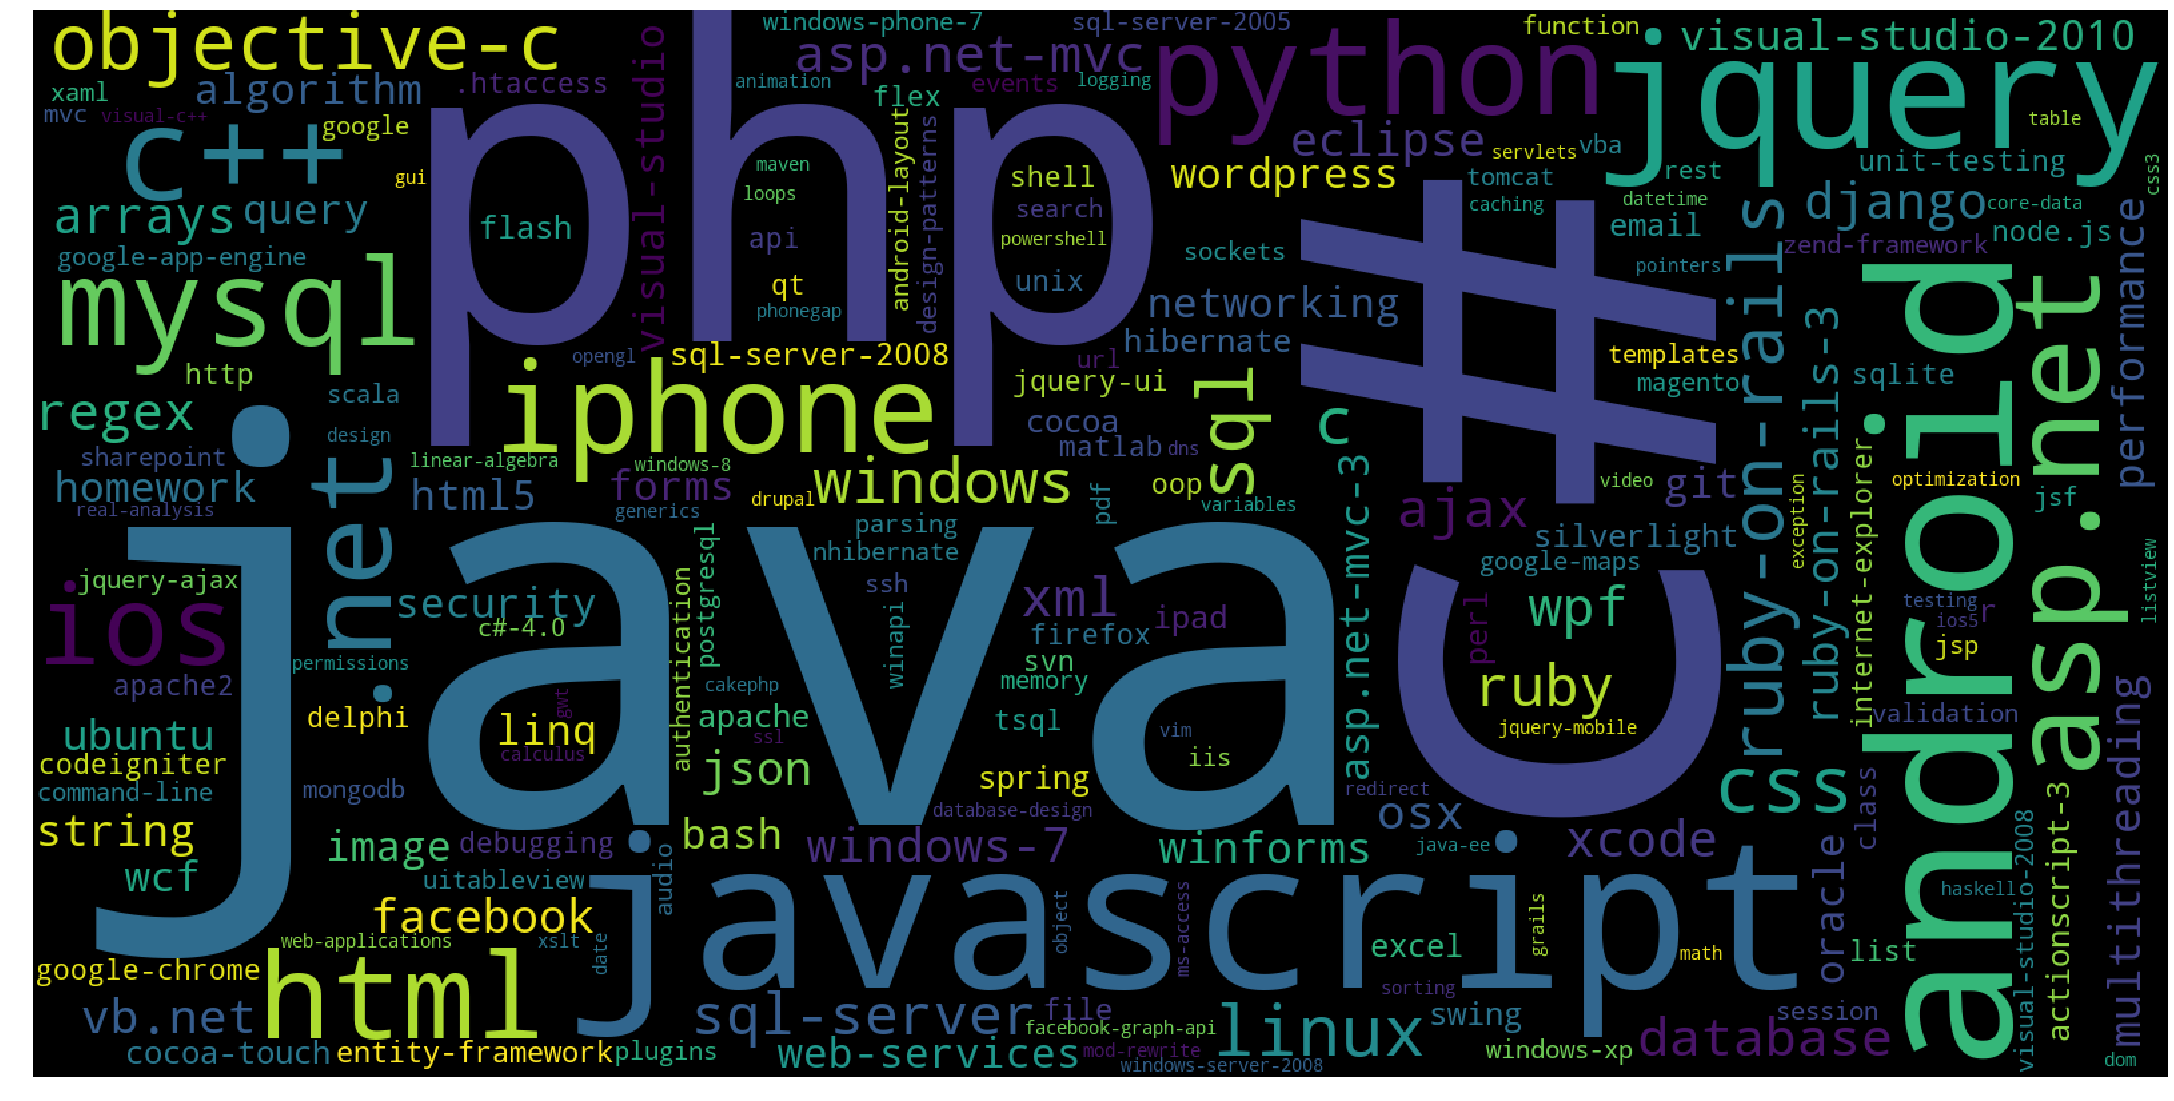

In [37]:
# Ploting word cloud
start = datetime.now()

#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(background_color='black',
                      width=1600,
                          height=800,
                    ).generate_from_frequencies(tag_count_dict)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig('./data/tag.png', dpi=300)
plt.show()
plt.close()

<b>Observations:</b><br />
A look at the word cloud shows that "c#", "java", "php", "asp.net", "javascript", "c++" are some of the most frequent tags.

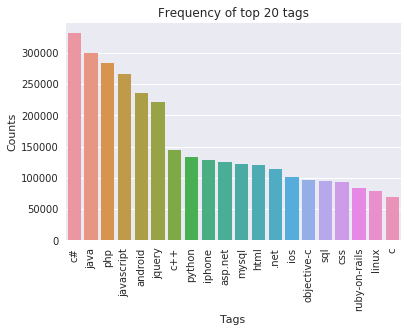

In [38]:
sns.barplot(x='Tag', y='Count', data=tag_count_df.iloc[0:20])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.title('Frequency of top 20 tags')
plt.xticks(rotation=90)
plt.show()
plt.close()

<b>Observations:</b><br />
1. Majority of the most frequent tags are programming language.
2. C# is the top most frequent programming language.
3. Android, IOS, Linux and windows are among the top most frequent operating systems.

## Questions Covered by Tags

In [39]:
# create dictionary having tag name & its index
tag_index_dict = {tag:index for index, tag 
                       in enumerate(vectorizer.get_feature_names())}

# get row, column indices of non-zero entries in CSR matrix
row_indices, col_indices = tag_vectorized.nonzero()
non_zero_indices_df = pd.DataFrame(list(zip(row_indices, col_indices)), 
                                   columns=['row', 'column'])
non_zero_indices_df.head()

,row,column
0,0,4337
1,0,4347
2,1,7927
3,1,33112
4,1,4338


In [5]:
if os.path.exists('./data/Coverage_info.csv'):
    coverage_info_df = pd.read_csv('./data/Coverage_info.csv', index_col=False)

else:
    covered_questions_dict = dict()
    total_ques = tag_vectorized.shape[0]
    coverage_info_list = list()

    # reset index of tag_count df
    tag_count_df = tag_count_df.reset_index(drop=True)

    for index, row in tag_count_df.iterrows():
        # get index of tag
        tag_index = tag_index_dict[row['Tag']]
        # get total number of questions covered by this
        temp_df = non_zero_indices_df[non_zero_indices_df['column'] == tag_index]
        questions_indices = set(temp_df['row'])

        # add to covered questions
        for item in questions_indices:
            covered_questions_dict[item] = 1

        # get cummultive coverage so far
        coverage = (len(covered_questions_dict) * 100.0) / total_ques

        coverage_info_list.append((row['Tag'], coverage,))

        if (index+1) % 100000 == 0:
            print(datetime.now(), 'Processed rows', index+1)

        #print('Questions coverage by top %d tags : %f '%(index+1, coverage,))
    coverage_info_df = pd.DataFrame(coverage_info_list, 
                                    columns=['Tag', 'Cumm_Coverage']) 
    
    coverage_info_df.to_csv('./data/Coverage_info.csv', index=False)
    
coverage_info_df.head()

,Tag,Cumm_Coverage
0,c#,7.881126
1,java,14.932548
2,php,21.619826
3,javascript,27.287519
4,android,32.041847


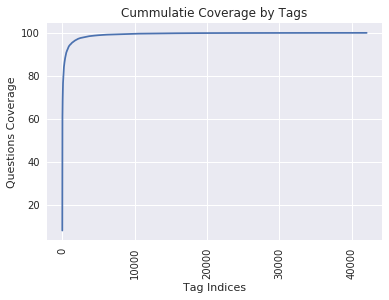

In [45]:
plt.plot(coverage_info_df['Cumm_Coverage'])
x_ticks = coverage_info_df['Tag'].tolist()
#plt.set_xticklabels(coverage_info_df['Tag'])
plt.xticks(rotation=90)
plt.xlabel('Tag Indices')
plt.ylabel('Questions Coverage')
plt.title('Cummulatie Coverage by Tags')
plt.show()
plt.close()

In [6]:
# we select the tags that cover upto 95%
#coverage_info_df = coverage_info_df[coverage_info_df['Cumm_Coverage'] <= 95.0]
# selecting the top 500 tags
coverage_info_df = coverage_info_df.iloc[0:500]
coverage_info_df.tail()

,Tag,Cumm_Coverage
495,amazon-s3,89.952845
496,attributes,89.956221
497,reference-request,90.007406
498,functions,90.051981
499,pdo,90.053051


In [7]:
required_tags = sorted(list(set(coverage_info_df['Tag'])))
print('Total tags selected', len(required_tags))

# save model to disk
pickle_out = open("./data/so_multilabels.pkl","wb")
pickle.dump(required_tags, pickle_out)
pickle_out.close()

Total tags selected 500


In [9]:
print("some tags selected :\n", required_tags[50:100])

some tags selected :
 ['backup', 'bash', 'batch', 'batch-file', 'binding', 'blackberry', 'bluetooth', 'boost', 'boot', 'browser', 'build', 'button', 'c', 'c#', 'c#-4.0', 'c++', 'c++11', 'caching', 'cakephp', 'calculus', 'calendar', 'canvas', 'casting', 'centos', 'character-encoding', 'charts', 'checkbox', 'class', 'clojure', 'cocoa', 'cocoa-touch', 'codeigniter', 'coding-style', 'coldfusion', 'collections', 'colors', 'com', 'combinatorics', 'combobox', 'command-line', 'compilation', 'compiler', 'complex-analysis', 'concurrency', 'configuration', 'constructor', 'cookies', 'core-data', 'crash', 'cron']


In [13]:
required_tags_set = set(required_tags)
# prepare a boolean array for the rows which contain the required tags
required_indices = [True if set(item.split()).intersection(required_tags_set) else False for item
                   in all_tags_df['Tags']]
print(required_indices[0:4])

[True, True, True, True]


# Sample from DB & Clean it

In [36]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
html_tags = re.compile('<.*?>')
special_chars = re.compile(r'[^A-Za-z#+]')

In [37]:
def clean_text(title, body_text, title_weight=1):
    
    # get code section from the body text
    code = str(re.findall(r'<code>(.*?)</code>', body_text, 
                          flags=re.DOTALL))

    # get non code section
    question = re.sub('<code>(.*?)</code>', ' ', body_text, 
                      flags=re.MULTILINE|re.DOTALL)
    
    # concatenate the title & question
    if title_weight == 1:
        text_data = title + ' ' + question
    else:
        text_data =str()
        
        for _ in range(0, title_weight):
            text_data += ' ' + title
            
        text_data = text_data + ' ' + question
    
    # remove HTML tags
    text_data = re.sub(html_tags, ' ', text_data)
    
    # remove special characters
    text_data = re.sub(special_chars, ' ', text_data)
    
    # convert to lower case
    text_data = text_data.lower()
    
    # remove stop words
    text_data_words = text_data.split()
    text_data_words = list(filter(lambda x : x not in stop_words, 
                                  text_data_words))
    
    # remove single letter words except c
    text_data_words = list(filter(lambda x : x=='c' or len(x) > 1, 
                                  text_data_words))
    
    # Find root word - stem the word
    text_data_words = [stemmer.stem(item) for item in text_data_words]
    
    # combine all words with space to get the cleaned text
    cleaned_text = ' '.join(text_data_words)
    
    return (cleaned_text, code,)  

In [38]:
def sample_and_clean_DB(db_in_path, required_indices, sample_size, title_weight=1):
    
    if os.path.isfile(cleaned_csv_path):
        print('Cleaned data csv already present in the path !!!')
        return
    
    conn = sqlite3.connect(db_in_path)
    df_no_dup = pd.read_sql_query("""SELECT Id, Title, Body, Tags FROM raw_data""", 
                                  conn)
    conn.close()
    
    # select only those rows where atleast one required tag is present
    print('Number of rows in the entire dataset :', df_no_dup.shape[0])
    df_no_dup = df_no_dup[required_indices]
    print('Number of rows selected based on required tags:', df_no_dup.shape[0])
    
    
    # take sample of data frame if opted
    sample_count = min(sample_size, df_no_dup.shape[0])
    df_no_dup = df_no_dup.sample(n=sample_count)
    df_no_dup = df_no_dup.reset_index(drop=True)
    # save id into a set
    id_list = df_no_dup['Id']
    tag_list = df_no_dup['Tags']
    
    print(datetime.now(), ' Sample of size %d taken'%(sample_count,))
    
    # STEP 2 : Separate out text & code from Body, also combine Title & Question as text data
    print(datetime.now(), ' Cleaning data frame started !!!')
    df_no_dup = df_no_dup.apply(lambda x : clean_text(x['Title'], x['Body'], title_weight), 
                                axis=1)
    print(datetime.now(), ' Cleaning data frame completed !!!')
    
    # separate out code and text
    df_no_dup_txt = [item[0] for item in df_no_dup]
    df_no_dup_code = [item[1] for item in df_no_dup]
    
    # create cleaned data frame
    df_no_dup = pd.DataFrame({ 'Id' : id_list,
                               'Question' : df_no_dup_txt, 
                              'Code' : df_no_dup_code,
                              'Tags' : tag_list}, 
                              index=range(df_no_dup.shape[0]))
    
    # re-order the column name
    df_no_dup = df_no_dup[['Id', 'Question', 'Code', 'Tags']]
    
    # get the number of rows where code is present
    code_count = len(list(filter(lambda x : x != str(), df_no_dup['Code'])))
    per_info = (code_count/ df_no_dup.shape[0]) * 100.0
    print('Size of the Sampled data frame: ', df_no_dup.shape[0])
    print('Number of rows having code: %d , Percentage: %f'%(code_count,
                                                             per_info,))
    
    # dump the deduped data to disk
    df_no_dup.to_csv(cleaned_csv_path, index=False)
    # 
    print('Cleaned & Sampled DF :\n', df_no_dup.head())
    
    print(datetime.now(), ' Done !!!')

In [39]:
sample_and_clean_DB(raw_db_path, required_indices, sample_size, title_weight)

Number of rows in the entire dataset : 4206315
Number of rows selected based on required tags: 3787914
2019-06-26 21:01:02.937691  Sample of size 300000 taken
2019-06-26 21:01:02.938300  Cleaning data frame started !!!
2019-06-26 21:05:28.440158  Cleaning data frame completed !!!
Size of the Sampled data frame:  300000
Number of rows having code: 300000 , Percentage: 100.000000
Cleaned & Sampled DF :
         Id                                           Question  \
0  2909527  adob effect script use chroma key filter layer...   
1  2895202  run applic eclips generat class find load exce...   
2  1345329  get post valu textarea use tinymc get post val...   
3  5449688  retri method call generic way retri method cal...   
4  1713764  forc repaint wxpython canva forc repaint wxpyt...   

                                                Code  \
0                                                 []   
1  ['&lt;directory&gt;path_to_target_folder_on_ra...   
2  [' tinyMCE.init({\n    // General

# Prepare Train, Test Data Sets

In [45]:
def prepare_datasets(cleaned_csv_path):
    
    if os.path.exists(final_train_feat_path) and os.path.exists(final_test_feat_path):
        print('Final Train, Test data frames features already found in the path !!!')
        return
    
    
    print(datetime.now(), 'Preparing the final features of train, test data frames')
    df = pd.read_csv(cleaned_csv_path, index_col=False)
    
    # partition to train test data
    df_train, df_test = train_test_split(df, test_size=0.30, shuffle=False)
    df_train = df_train.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    # save train test data to disk
    df_train[['Id', 'Tags']].to_csv('./data/Final_train_df_label.csv', index=False)
    df_test[['Id', 'Tags']].to_csv('./data/Final_test_df_label.csv', index=False)
    
    # slice the dataframe to required columns
    df_train = df_train['Question']
    df_test = df_test['Question']
    
    # create text vectorizer object
    vectorizer = CountVectorizer(min_df=0.0005, max_df=0.95, max_features=20000, 
                                 ngram_range=(1,4), tokenizer=lambda x : x.split())
    
    
    # 1- Featurization of the questions data
    
    # fit to the train data
    print(datetime.now(), ' Start: Vectorizing train, test questions ...')
    vectorizer.fit(df_train)
    feat_names_list = list(vectorizer.get_feature_names())
    
    # save the feature names list to disk
    pickle_out = open("./data/feature_names_list.pkl","wb")
    pickle.dump(feat_names_list, pickle_out)
    pickle_out.close()
    
    # transform the feature columns
    df_train = vectorizer.transform(df_train)
    df_test = vectorizer.transform(df_test)
    print(datetime.now(), ' End: Vectorizing train questions ')
    
    print('Train DF shape :', df_train.shape)
    print('Test DF shape :', df_test.shape)
    
    # write the train, test numpy sparse matrices to disk
    scipy.sparse.save_npz(final_train_feat_path, df_train)
    scipy.sparse.save_npz(final_test_feat_path, df_test)
    
    print(datetime.now(), ' Done !!!')

In [46]:
 prepare_datasets(cleaned_csv_path)

2019-06-26 21:36:08.640200 Preparing the final features of train, test data frames
2019-06-26 21:36:12.058076  Start: Vectorizing train, test questions ...
2019-06-26 21:39:59.634761  End: Vectorizing train questions 
Train DF shape : (210000, 12526)
Test DF shape : (90000, 12526)
2019-06-26 21:40:08.274760  Done !!!


# Procedure Summary

<ul>
<li> Read raw data from the csv file and save it to DB </li>
<li> Basic EDA based on number of tags, questions, tags per questions, most frequent tags etc </li>
<li> Idenified the top tags that has maximal coverage, the tags that covers maority of the questions </li>
<li> Due to limited computation power restricted the number of top tags to 500 and the sample size of 0.3 M </li>
<li> Cleaned all the data points in the sample dataset </li>
<li> Given high weightage to title  than the question (3:1)  to improve the performance of model </li>
<li> The data set is partitioned into train & test </li>
<li> The text data is vectorized using count vectorizer </li>
<li> The final train, test dataset is prepared for multilabeled classification </li>
</ul>

# Conclusion

<ul>
<li> The top 500 tags selected covers 90+ % of the questions </li>
<li> The train, test dataset for multi-labeled classification problem is prepared</li>
</ul>